In [ ]:
#####    9517 group project    #####

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/COMP9517_ZXCZH /content/

Mounted at /content/drive


#EfficientNet

In [ ]:
!pip install efficientnet_pytorch

<ipython-input-5-03f29b5eee30>:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Loaded pretrained weights for efficientnet-b0


Epoch 1/10:   0%|          | 0/150 [00:00<?, ?batch/s]<ipython-input-5-03f29b5eee30>:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 150/150 [01:25<00:00,  1.75batch/s, loss=0.645, acc=84.9%]


Val Acc: 95.2%
--------------------------------------------------


Epoch 2/10: 100%|██████████| 150/150 [01:21<00:00,  1.84batch/s, loss=0.143, acc=95.5%]


Val Acc: 96.7%
--------------------------------------------------


Epoch 3/10: 100%|██████████| 150/150 [01:20<00:00,  1.85batch/s, loss=0.087, acc=97.3%]


Val Acc: 97.1%
--------------------------------------------------


Epoch 4/10: 100%|██████████| 150/150 [01:24<00:00,  1.78batch/s, loss=0.069, acc=97.9%]


Val Acc: 97.2%
--------------------------------------------------


Epoch 5/10: 100%|██████████| 150/150 [01:20<00:00,  1.85batch/s, loss=0.050, acc=98.4%]


Val Acc: 96.9%
--------------------------------------------------


Epoch 6/10: 100%|██████████| 150/150 [01:18<00:00,  1.92batch/s, loss=0.048, acc=98.4%]


Val Acc: 96.1%
--------------------------------------------------


Epoch 7/10: 100%|██████████| 150/150 [01:17<00:00,  1.94batch/s, loss=0.044, acc=98.6%]


Val Acc: 97.5%
--------------------------------------------------


Epoch 8/10: 100%|██████████| 150/150 [01:18<00:00,  1.92batch/s, loss=0.034, acc=98.9%]


Val Acc: 98.0%
--------------------------------------------------


Epoch 9/10: 100%|██████████| 150/150 [01:19<00:00,  1.90batch/s, loss=0.032, acc=99.0%]


Val Acc: 97.9%
--------------------------------------------------


Epoch 10/10: 100%|██████████| 150/150 [01:23<00:00,  1.79batch/s, loss=0.037, acc=98.8%]


Val Acc: 97.8%
--------------------------------------------------


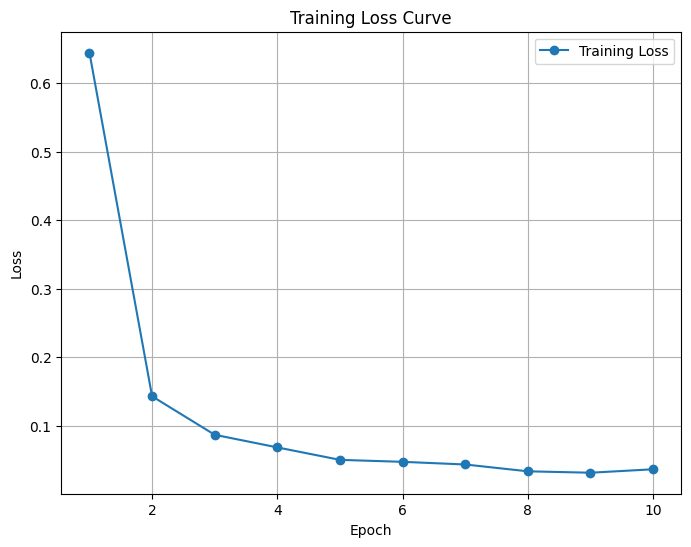


Training accuracy: 98.8% | Verification accuracy: 97.8%
Normal training


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

# device layout
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# dataset allocation
train_dir = '/content/COMP9517_ZXCZH/train'
test_dir = '/content/COMP9517_ZXCZH/test'

# Data enhancement pipeline
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data loading
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2, pin_memory=True)

# Model initialization
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=15)
model.to(device)

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Initialize GradScaler
scaler = GradScaler()

# Save train loss for curve
train_loss_list = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            avg_loss = train_loss / total
            acc = 100 * correct / total

            pbar.set_postfix({
                "loss": f"{avg_loss:.3f}",
                "acc": f"{acc:.1f}%"
            })

    train_loss_list.append(avg_loss)

    # Validation stage
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Val Acc: {100 * val_correct / val_total:.1f}%")
    print("-" * 50)

# Plot Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Overfitting judgment
final_train_acc = 100 * correct / total
final_val_acc = 100 * val_correct / val_total
print(f"\nTraining accuracy: {final_train_acc:.1f}% | Verification accuracy: {final_val_acc:.1f}%")
if final_train_acc - final_val_acc > 10:
    print("Overfitting detected!")
else:
    print("Normal training")


Efficientnet Final Evaluation on Test Set:
Efficientnet Test dataset Accuracy: 98.00%
Efficientnet Test dataset Precision: 98.05%
Efficientnet Test dataset Recall: 98.00%
Efficientnet Test dataset F1-score: 98.00%

Efficientnet Final classification report:
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       160
     Airport       0.99      0.98      0.99       160
       Beach       1.00      0.96      0.98       160
        City       0.96      1.00      0.98       160
      Desert       0.94      0.99      0.96       160
      Forest       0.99      0.97      0.98       160
   Grassland       0.99      0.98      0.99       160
     Highway       0.95      0.99      0.97       160
        Lake       0.96      1.00      0.98       160
    Mountain       0.99      0.95      0.97       160
     Parking       0.98      0.99      0.98       160
        Port       1.00      0.99      1.00       160
     Railway       0.99      0.94      

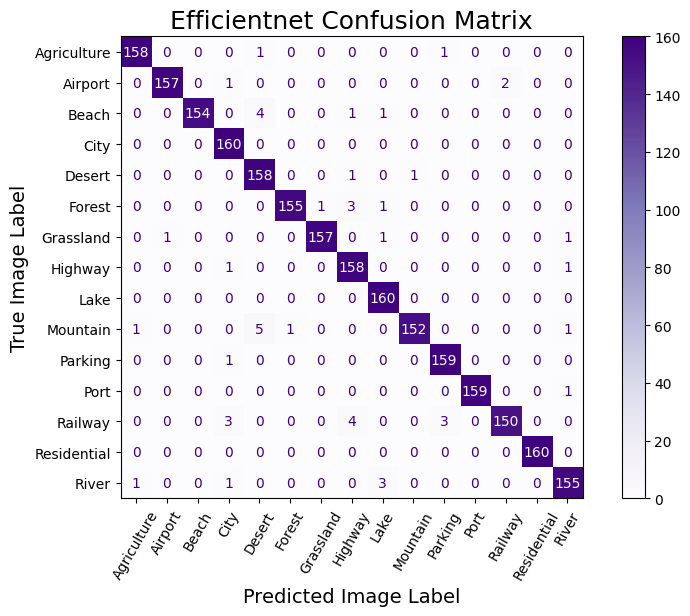

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_validate
#____________________Efficientnet Final Evaluation______________________________
print("\nEfficientnet Final Evaluation on Test Set:")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Use accuracy, precision, recall and f1 as the evaluation metrics.
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Efficientnet Test dataset Accuracy: {accuracy * 100:.2f}%")
print(f"Efficientnet Test dataset Precision: {precision * 100:.2f}%")
print(f"Efficientnet Test dataset Recall: {recall * 100:.2f}%")
print(f"Efficientnet Test dataset F1-score: {f1 * 100:.2f}%")

# Efficientnet Classification report.
print("\nEfficientnet Final classification report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Efficientnet Confusion matrix:
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Purples', xticks_rotation=60, ax=ax)
plt.title("Efficientnet Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Image Label", fontsize=14)
plt.ylabel("True Image Label", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Imbalanced dataset--only re-weighting and re-sampling

In [ ]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from collections import defaultdict, Counter
import os

if __name__ == '__main__':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

    # data path
    train_dir = '/content/COMP9517_ZXCZH/train'
    test_dir = '/content/COMP9517_ZXCZH/test'

    # Custom long mantissa data set class
    class LongTailDataset(Dataset):
        def __init__(self, original_dataset, class_distribution):
            self.class_distribution = class_distribution
            self.samples_by_class = defaultdict(list)
            for idx, (path, label) in enumerate(original_dataset.samples):
                self.samples_by_class[label].append(idx)
            self.indices = []
            for cls in sorted(class_distribution.keys()):
                target = class_distribution[cls]
                available = self.samples_by_class[cls]
                if target > len(available):
                    repeat = target // len(available)
                    remain = target % len(available)
                    selected = available * repeat + available[:remain]
                else:
                    selected = np.random.choice(available, target, replace=False)
                self.indices.extend(selected)
            np.random.shuffle(self.indices)
            self.dataset = original_dataset

        def __len__(self): return len(self.indices)
        def __getitem__(self, idx): return self.dataset[self.indices[idx]]

    # Define a long-tail distribution
    class_dist = {i: 800 - 50*i for i in range(15)}  # 800,750,...,50
    class_dist = {k: max(v,50) for k,v in class_dist.items()}

    # Data augmentation
    base_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the original dataset
    original_train = datasets.ImageFolder(train_dir, transform=base_transform)

    # Create a long-tail dataset
    longtail_train = LongTailDataset(original_train, class_dist)

    # Display distribution
    labels = [longtail_train.dataset.targets[i] for i in longtail_train.indices]
    print("Long tail distribution verification:")
    for cls, count in Counter(labels).items():
        print(f"Class {cls+1}: {count} pictures")

    # Sampler configuration
    class_counts = np.array([class_dist[cls] for cls in sorted(class_dist)])
    class_weights = 1. / class_counts
    samples_weights = np.concatenate([np.full(class_dist[cls], w)
                                    for cls, w in zip(sorted(class_dist), class_weights)])

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(samples_weights).float(),
        num_samples=len(samples_weights),
        replacement=True
    )

    # data loading
    train_loader = DataLoader(
        longtail_train,
        batch_size=32,
        sampler=sampler,
        num_workers=2,
        pin_memory=True
    )

    test_dataset = datasets.ImageFolder(test_dir, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)

    # Model initialization
    model1 = EfficientNet.from_pretrained('efficientnet-b0', num_classes=15)
    for param in model1.parameters():
        param.requires_grad = False
    for block in model1._blocks[-2:]:
        for param in block.parameters():
            param.requires_grad = True
    model1._fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model1._fc.in_features, 15)
    )
    model1.to(device)

    # loss function
    criterion = nn.CrossEntropyLoss(
        weight=torch.from_numpy(class_weights).float().to(device)
    )

    # optimizer
    optimizer = optim.AdamW([
        {'params': model1._blocks[-2:].parameters(), 'lr': 3e-4},
        {'params': model1._fc.parameters(), 'lr': 1e-3}
    ])

    # Training
    scaler = torch.amp.GradScaler()
    for epoch in range(10):
        model1.train()
        total_loss = correct = total = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model1(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "loss": f"{total_loss/(total//32):.3f}",
                "acc": f"{100*correct/total:.1f}%"
            })

        # Validation
        model1.eval()
        val_correct = val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model1(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        print(f"Verification accuracy: {100*val_correct/val_total:.1f}%")
        print("-"*50)

Long tail distribution verification:
Class 4: 650 pictures
Class 6: 550 pictures
Class 3: 700 pictures
Class 9: 400 pictures
Class 11: 300 pictures
Class 1: 800 pictures
Class 7: 500 pictures
Class 2: 750 pictures
Class 8: 450 pictures
Class 12: 250 pictures
Class 10: 350 pictures
Class 5: 600 pictures
Class 13: 200 pictures
Class 14: 150 pictures
Class 15: 100 pictures
Loaded pretrained weights for efficientnet-b0


Epoch 1/10:   0%|          | 0/211 [00:00<?, ?it/s]<ipython-input-6-c01ea8453d86>:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 211/211 [00:20<00:00, 10.17it/s, loss=0.993, acc=75.4%]


Verification accuracy: 91.4%
--------------------------------------------------


Epoch 2/10: 100%|██████████| 211/211 [00:21<00:00,  9.75it/s, loss=0.282, acc=91.7%]


Verification accuracy: 93.6%
--------------------------------------------------


Epoch 3/10: 100%|██████████| 211/211 [00:21<00:00,  9.74it/s, loss=0.202, acc=93.8%]


Verification accuracy: 94.3%
--------------------------------------------------


Epoch 4/10: 100%|██████████| 211/211 [00:22<00:00,  9.45it/s, loss=0.152, acc=95.4%]


Verification accuracy: 94.4%
--------------------------------------------------


Epoch 5/10: 100%|██████████| 211/211 [00:22<00:00,  9.49it/s, loss=0.125, acc=96.1%]


Verification accuracy: 95.3%
--------------------------------------------------


Epoch 6/10: 100%|██████████| 211/211 [00:22<00:00,  9.41it/s, loss=0.114, acc=96.2%]


Verification accuracy: 94.8%
--------------------------------------------------


Epoch 7/10: 100%|██████████| 211/211 [00:22<00:00,  9.41it/s, loss=0.104, acc=96.8%]


Verification accuracy: 94.6%
--------------------------------------------------


Epoch 8/10: 100%|██████████| 211/211 [00:22<00:00,  9.38it/s, loss=0.088, acc=97.3%]


Verification accuracy: 95.6%
--------------------------------------------------


Epoch 9/10: 100%|██████████| 211/211 [00:22<00:00,  9.29it/s, loss=0.086, acc=97.5%]


Verification accuracy: 95.7%
--------------------------------------------------


Epoch 10/10: 100%|██████████| 211/211 [00:22<00:00,  9.32it/s, loss=0.080, acc=97.3%]


Verification accuracy: 95.3%
--------------------------------------------------



Efficientnet Final Evaluation on Test Set:
Efficientnet Test dataset Accuracy: 95.50%
Efficientnet Test dataset Precision: 95.54%
Efficientnet Test dataset Recall: 95.50%
Efficientnet Test dataset F1-score: 95.46%

Efficientnet Final classification report:
              precision    recall  f1-score   support

 Agriculture       0.96      0.98      0.97       160
     Airport       0.97      0.96      0.96       160
       Beach       0.94      0.96      0.95       160
        City       0.95      0.97      0.96       160
      Desert       0.95      0.94      0.95       160
      Forest       0.95      0.96      0.96       160
   Grassland       0.94      0.99      0.96       160
     Highway       0.97      0.96      0.97       160
        Lake       0.90      0.93      0.91       160
    Mountain       0.92      0.96      0.94       160
     Parking       0.99      0.97      0.98       160
        Port       0.98      0.97      0.98       160
     Railway       0.95      0.95      

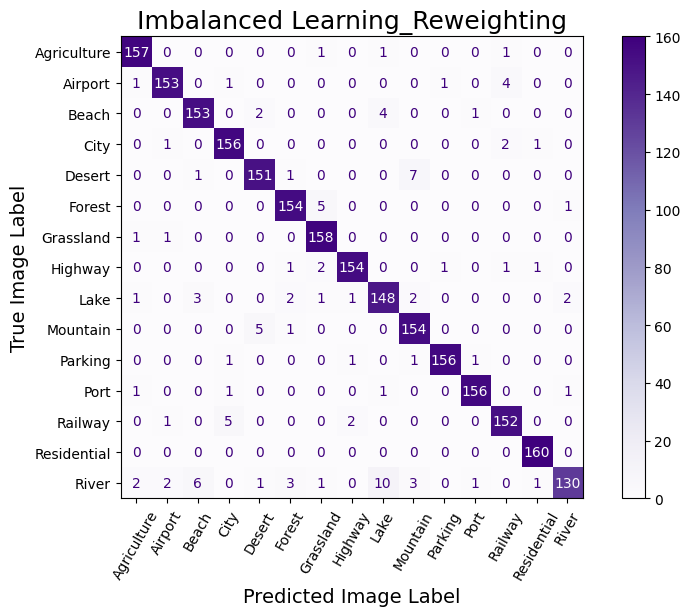

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_validate
#____________________Efficientnet Final Evaluation______________________________
print("\nEfficientnet Final Evaluation on Test Set:")
model1.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Use accuracy, precision, recall and f1 as the evaluation metrics.
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Efficientnet Test dataset Accuracy: {accuracy * 100:.2f}%")
print(f"Efficientnet Test dataset Precision: {precision * 100:.2f}%")
print(f"Efficientnet Test dataset Recall: {recall * 100:.2f}%")
print(f"Efficientnet Test dataset F1-score: {f1 * 100:.2f}%")

# Efficientnet Classification report.
print("\nEfficientnet Final classification report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Efficientnet Confusion matrix:
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Purples', xticks_rotation=60, ax=ax)
plt.title("Imbalanced Learning_Reweighting", fontsize=18)
plt.xlabel("Predicted Image Label", fontsize=14)
plt.ylabel("True Image Label", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Data augmentation for minority classes based on re-sample and re-weight


In [ ]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from collections import defaultdict, Counter
import os

if __name__ == '__main__':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

    # data path
    train_dir = '/content/COMP9517_ZXCZH/train'
    test_dir = '/content/COMP9517_ZXCZH/test'

    # ==================== Data augmentation strategy ====================
    majority_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    minority_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.8),
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.3),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.7, scale=(0.05, 0.2)),
        transforms.GaussianBlur(kernel_size=5),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    class LongTailDataset(Dataset):
        def __init__(self, original_dataset, class_distribution, majority_trans, minority_trans):
            self.class_dist = class_distribution
            self.majority_trans = majority_trans
            self.minority_trans = minority_trans

            # Establish a category index mapping
            self.samples_by_class = defaultdict(list)
            for idx, (path, label) in enumerate(original_dataset.samples):
                self.samples_by_class[label].append(idx)

            # Sampling logic
            self.indices = []
            for cls in sorted(class_distribution.keys()):
                target = class_distribution[cls]
                available = self.samples_by_class[cls]
                if target > len(available):
                    repeat = target // len(available)
                    remain = target % len(available)
                    selected = available * repeat + available[:remain]
                else:
                    selected = np.random.choice(available, target, replace=False)
                self.indices.extend(selected)
            np.random.shuffle(self.indices)

            # Storage tags are used for quick access
            self.targets = [original_dataset.samples[i][1] for i in self.indices]
            self.dataset = original_dataset

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            img, label = self.dataset[self.indices[idx]]  # Obtain the original image
            # Application differentiation enhancement
            if self.class_dist[label] <= 200:  # Minority class threshold
                img = self.minority_trans(img)
            else:
                img = self.majority_trans(img)
            return img, label

    # ==================== main process ====================
    class_dist = {i: 800 - 50*i for i in range(15)}
    class_dist = {k: max(v,50) for k,v in class_dist.items()}

    original_train = datasets.ImageFolder(train_dir, transform=None)

    longtail_train = LongTailDataset(
        original_train,
        class_dist,
        majority_trans=majority_transforms,
        minority_trans=minority_transforms
    )


    print("Long tail distribution verification:")
    for cls, count in Counter(longtail_train.targets).items():
        print(f"Class {cls}: {count} samples")

    # ==================== sampler ====================
    class_counts = np.array([class_dist[cls] for cls in sorted(class_dist)])
    class_weights = 1. / class_counts
    samples_weights = np.concatenate([np.full(class_dist[cls], w)
                                    for cls, w in zip(sorted(class_dist), class_weights)])

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(samples_weights).float(),
        num_samples=len(samples_weights),
        replacement=True
    )

    train_loader = DataLoader(
        longtail_train,
        batch_size=32,
        sampler=sampler,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True
    )

    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)

    # ==================== model defintion ====================
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=15)
    # Freeze the feature layer
    for param in model.parameters():
        param.requires_grad = False
    # Thaw the last two modules
    for block in model._blocks[-2:]:
        for param in block.parameters():
            param.requires_grad = True
    # Replace the classification head
    model._fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model._fc.in_features, 15)
    )
    model.to(device)

    # ==================== Training configuration ====================
    criterion = nn.CrossEntropyLoss(
        weight=torch.from_numpy(class_weights).float().to(device)
    )

    optimizer = optim.AdamW([
        {'params': model._blocks[-2:].parameters(), 'lr': 3e-4},
        {'params': model._fc.parameters(), 'lr': 1e-3}
    ])

    # ==================== The Training Cycle ====================
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    for epoch in range(10):
        model.train()
        total_loss = correct = total = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "loss": f"{total_loss/(total//32 + 1e-5):.3f}",
                "acc": f"{100*correct/total:.1f}%"
            })


        model.eval()
        val_correct = val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        print(f"Val Acc: {100*val_correct/val_total:.1f}%")
        print("-"*50)

Long tail distribution verification:
Class 10: 300 samples
Class 4: 600 samples
Class 0: 800 samples
Class 7: 450 samples
Class 3: 650 samples
Class 6: 500 samples
Class 9: 350 samples
Class 8: 400 samples
Class 5: 550 samples
Class 1: 750 samples
Class 2: 700 samples
Class 12: 200 samples
Class 11: 250 samples
Class 14: 100 samples
Class 13: 150 samples
Loaded pretrained weights for efficientnet-b0


Epoch 1/10:   0%|          | 0/211 [00:00<?, ?it/s]<ipython-input-7-2ae4e6acf04a>:168: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
Epoch 1/10: 100%|██████████| 211/211 [00:24<00:00,  8.51it/s, loss=0.900, acc=79.4%]


Val Acc: 81.4%
--------------------------------------------------


Epoch 2/10: 100%|██████████| 211/211 [00:27<00:00,  7.59it/s, loss=0.255, acc=93.2%]


Val Acc: 84.5%
--------------------------------------------------


Epoch 3/10: 100%|██████████| 211/211 [00:27<00:00,  7.62it/s, loss=0.181, acc=94.9%]


Val Acc: 88.0%
--------------------------------------------------


Epoch 4/10: 100%|██████████| 211/211 [00:24<00:00,  8.67it/s, loss=0.153, acc=95.7%]


Val Acc: 89.0%
--------------------------------------------------


Epoch 5/10: 100%|██████████| 211/211 [00:25<00:00,  8.20it/s, loss=0.128, acc=96.5%]


Val Acc: 90.7%
--------------------------------------------------


Epoch 6/10: 100%|██████████| 211/211 [00:27<00:00,  7.70it/s, loss=0.117, acc=96.5%]


Val Acc: 90.0%
--------------------------------------------------


Epoch 7/10: 100%|██████████| 211/211 [00:25<00:00,  8.38it/s, loss=0.098, acc=96.9%]


Val Acc: 91.2%
--------------------------------------------------


Epoch 8/10: 100%|██████████| 211/211 [00:26<00:00,  8.06it/s, loss=0.106, acc=97.0%]


Val Acc: 90.9%
--------------------------------------------------


Epoch 9/10: 100%|██████████| 211/211 [00:25<00:00,  8.16it/s, loss=0.093, acc=97.1%]


Val Acc: 93.0%
--------------------------------------------------


Epoch 10/10: 100%|██████████| 211/211 [00:25<00:00,  8.39it/s, loss=0.084, acc=97.6%]


Val Acc: 92.5%
--------------------------------------------------



Efficientnet Final Evaluation on Test Set:
Efficientnet Test dataset Accuracy: 91.62%
Efficientnet Test dataset Precision: 92.59%
Efficientnet Test dataset Recall: 91.62%
Efficientnet Test dataset F1-score: 91.11%

Efficientnet Final classification report:
              precision    recall  f1-score   support

 Agriculture       0.90      1.00      0.95       160
     Airport       0.88      0.99      0.93       160
       Beach       0.92      0.98      0.95       160
        City       0.80      0.98      0.88       160
      Desert       0.94      0.91      0.92       160
      Forest       0.92      0.99      0.96       160
   Grassland       0.99      0.93      0.96       160
     Highway       0.92      0.96      0.94       160
        Lake       0.78      0.98      0.87       160
    Mountain       0.90      0.96      0.93       160
     Parking       0.96      0.99      0.98       160
        Port       0.99      0.97      0.98       160
     Railway       0.99      0.70      

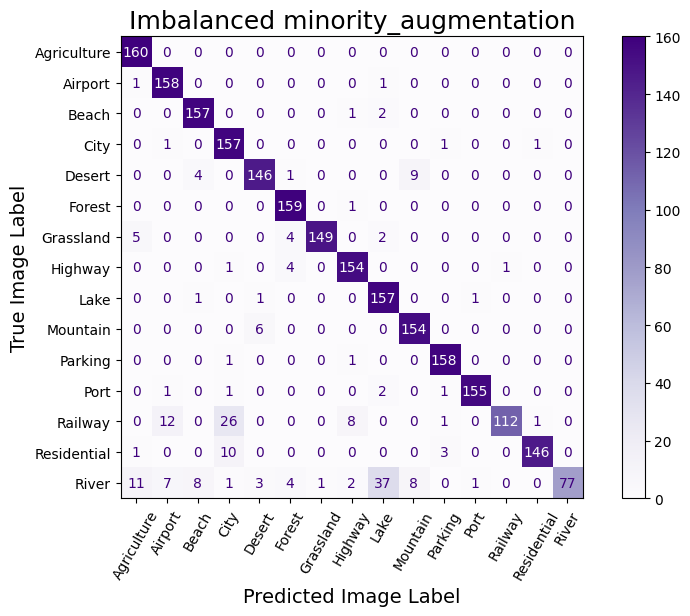

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_validate
#____________________Efficientnet Final Evaluation______________________________
print("\nEfficientnet Final Evaluation on Test Set:")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Use accuracy, precision, recall and f1 as the evaluation metrics.
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Efficientnet Test dataset Accuracy: {accuracy * 100:.2f}%")
print(f"Efficientnet Test dataset Precision: {precision * 100:.2f}%")
print(f"Efficientnet Test dataset Recall: {recall * 100:.2f}%")
print(f"Efficientnet Test dataset F1-score: {f1 * 100:.2f}%")

# Efficientnet Classification report.
print("\nEfficientnet Final classification report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Efficientnet Confusion matrix:
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Purples', xticks_rotation=60, ax=ax)
plt.title("Imbalanced minority_augmentation", fontsize=18)
plt.xlabel("Predicted Image Label", fontsize=14)
plt.ylabel("True Image Label", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Based on re-sample and re-weight, use PRA data augmentation

In [ ]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from collections import defaultdict
import os
import random
from PIL import Image


class ProgressiveRegionAugment:
    def __init__(self, class_dist):
        self.max_samples = max(class_dist.values())
        self.class_dist = class_dist
        self.base_aug = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(p=0.5)
        ])

    def __call__(self, img, label):
        alpha = 1 - (self.class_dist[label] / self.max_samples)

        # Phase One: Enhancement of Basic Geometry
        img = self.base_aug(img)

        # Phase Two: Progressive Enhancement
        img = self._region_aware_aug(img, alpha)

        # Convert to Tensor and standardize
        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(img,
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])
        return img

    def _region_aware_aug(self, img, alpha):
        # Generate the regional mask
        w, h = img.size
        grid_size = 8
        mask = torch.rand((h//grid_size, w//grid_size)) < alpha
        mask = transforms.functional.resize(mask.unsqueeze(0), (h, w))[0]

        img = self._apply_selective_aug(img, mask.numpy(), alpha)
        return img

    def _apply_selective_aug(self, img, mask, alpha):
        # color vibrance
        img = transforms.functional.adjust_sharpness(img, 1 + alpha)

        # Geometric transformation
        if alpha > 0.3:
            angle = random.uniform(-15*alpha, 15*alpha)
            img = transforms.functional.rotate(img, angle)

        # perspective transformation
        if alpha > 0.5:
            w, h = img.size
            distortion = 10 * alpha


            start_points = [
                [0, 0],
                [w-1, 0],
                [w-1, h-1],
                [0, h-1]
            ]
            end_points = [
                [random.randint(-int(distortion), int(distortion)),
                 random.randint(-int(distortion), int(distortion))],
                [w-1 - random.randint(-int(distortion), int(distortion)),
                 random.randint(-int(distortion), int(distortion))],
                [w-1 - random.randint(-int(distortion), int(distortion)),
                 h-1 - random.randint(-int(distortion), int(distortion))],
                [random.randint(-int(distortion), int(distortion)),
                 h-1 - random.randint(-int(distortion), int(distortion))]
            ]


            img = transforms.functional.perspective(
                img,
                start_points,
                end_points,
                interpolation=transforms.InterpolationMode.BILINEAR,
                fill=random.randint(0, 255)
            )

        # erasing randomly
        if random.random() < 0.3 + 0.4*alpha:
            img = self._random_erase(img, alpha)

        return img

    def _random_erase(self, img, alpha):
        img_tensor = transforms.functional.to_tensor(img)
        h, w = img_tensor.shape[1], img_tensor.shape[2]

        scale = (0.02 + 0.1*alpha, 0.1 + 0.2*alpha)
        ratio = (0.3, 3.3)

        erase_transform = transforms.RandomErasing(
            p=0.7,
            scale=scale,
            ratio=ratio,
            value=random.random()
        )
        return transforms.functional.to_pil_image(erase_transform(img_tensor))

class LongTailDataset(Dataset):
    def __init__(self, original_dataset, class_distribution):
        self.class_dist = class_distribution
        self.samples_by_class = defaultdict(list)
        self.original_dataset = original_dataset

        # index
        for idx, (path, label) in enumerate(original_dataset.samples):
            self.samples_by_class[label].append(idx)

        # sampling logic
        self.indices = []
        for cls in sorted(class_distribution.keys()):
            target = class_distribution[cls]
            available = self.samples_by_class[cls]
            if target > len(available):
                repeat = target // len(available)
                remain = target % len(available)
                selected = available * repeat + available[:remain]
            else:
                selected = np.random.choice(available, target, replace=False)
            self.indices.extend(selected)
        np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        img_path, label = self.original_dataset.samples[original_idx]
        img = Image.open(img_path).convert('RGB')
        return pra_augment(img, label), label

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    train_dir = '/content/COMP9517_ZXCZH/train'
    test_dir = '/content/COMP9517_ZXCZH/test'

    # long-tail
    class_dist = {i: 800 - 50*i for i in range(15)}
    class_dist = {k: max(v,50) for k,v in class_dist.items()}

    # Initialize the enhancer
    pra_augment = ProgressiveRegionAugment(class_dist)

    # dataset
    original_train = datasets.ImageFolder(train_dir)
    longtail_train = LongTailDataset(original_train, class_dist)

    # Verify the distribution
    print("Long tail distribution verification:")
    label_counts = defaultdict(int)
    for i in longtail_train.indices:
        label = original_train.targets[i]
        label_counts[label] += 1
    for cls in sorted(label_counts.keys()):
        print(f"Class {cls}: {label_counts[cls]} samples")

    # Sampling
    class_counts = np.array([class_dist[cls] for cls in sorted(class_dist)])
    class_weights = 1. / class_counts
    samples_weights = np.concatenate([np.full(class_dist[cls], w)
                                    for cls, w in zip(sorted(class_dist), class_weights)])

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(samples_weights).float(),
        num_samples=len(samples_weights),
        replacement=True
    )


    max_workers = min(4, os.cpu_count()//2)
    train_loader = DataLoader(
        longtail_train,
        batch_size=32,
        sampler=sampler,
        num_workers=max_workers,
        pin_memory=True,
        persistent_workers=True
    )

    # Test set transformation
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)


    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=15)
    for param in model.parameters():
        param.requires_grad = False
    for block in model._blocks[-2:]:
        for param in block.parameters():
            param.requires_grad = True
    model._fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model._fc.in_features, 15)
    )
    model.to(device)

    # Training configuration
    criterion = nn.CrossEntropyLoss(
        weight=torch.from_numpy(class_weights).float().to(device)
    )
    optimizer = optim.AdamW([
        {'params': model._blocks[-2:].parameters(), 'lr': 3e-4},
        {'params': model._fc.parameters(), 'lr': 1e-3}
    ])
    if torch.cuda.is_available():
        scaler = torch.cuda.amp.GradScaler()
    else:

        scaler = torch.amp.GradScaler(enabled=False)

    # Training
    for epoch in range(10):
        model.train()
        total_loss = correct = total = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "loss": f"{total_loss/(total//32 + 1e-5):.3f}",
                "acc": f"{100*correct/total:.1f}%"
            })

        # Validation
        model.eval()
        val_correct = val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        print(f"Validation Accuracy: {100*val_correct/val_total:.1f}%")
        print("-"*50)

<ipython-input-8-c1086383a3ce>:227: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Long tail distribution verification:
Class 0: 800 samples
Class 1: 750 samples
Class 2: 700 samples
Class 3: 650 samples
Class 4: 600 samples
Class 5: 550 samples
Class 6: 500 samples
Class 7: 450 samples
Class 8: 400 samples
Class 9: 350 samples
Class 10: 300 samples
Class 11: 250 samples
Class 12: 200 samples
Class 13: 150 samples
Class 14: 100 samples
Loaded pretrained weights for efficientnet-b0


Epoch 1/10: 100%|██████████| 211/211 [00:49<00:00,  4.30it/s, loss=0.978, acc=77.6%]


Validation Accuracy: 87.4%
--------------------------------------------------


Epoch 2/10: 100%|██████████| 211/211 [00:49<00:00,  4.23it/s, loss=0.245, acc=93.2%]


Validation Accuracy: 89.3%
--------------------------------------------------


Epoch 3/10: 100%|██████████| 211/211 [00:49<00:00,  4.29it/s, loss=0.158, acc=95.5%]


Validation Accuracy: 88.7%
--------------------------------------------------


Epoch 4/10: 100%|██████████| 211/211 [00:48<00:00,  4.31it/s, loss=0.133, acc=96.1%]


Validation Accuracy: 90.8%
--------------------------------------------------


Epoch 5/10: 100%|██████████| 211/211 [00:49<00:00,  4.28it/s, loss=0.095, acc=97.2%]


Validation Accuracy: 91.4%
--------------------------------------------------


Epoch 6/10: 100%|██████████| 211/211 [00:49<00:00,  4.28it/s, loss=0.097, acc=97.1%]


Validation Accuracy: 91.4%
--------------------------------------------------


Epoch 7/10: 100%|██████████| 211/211 [00:49<00:00,  4.26it/s, loss=0.081, acc=97.5%]


Validation Accuracy: 90.8%
--------------------------------------------------


Epoch 8/10: 100%|██████████| 211/211 [00:49<00:00,  4.23it/s, loss=0.067, acc=98.1%]


Validation Accuracy: 91.8%
--------------------------------------------------


Epoch 9/10: 100%|██████████| 211/211 [00:50<00:00,  4.18it/s, loss=0.073, acc=97.7%]


Validation Accuracy: 92.7%
--------------------------------------------------


Epoch 10/10: 100%|██████████| 211/211 [00:50<00:00,  4.18it/s, loss=0.066, acc=98.0%]


Validation Accuracy: 92.2%
--------------------------------------------------



Efficientnet Final Evaluation on Test Set:
Efficientnet Test dataset Accuracy: 92.96%
Efficientnet Test dataset Precision: 93.42%
Efficientnet Test dataset Recall: 92.96%
Efficientnet Test dataset F1-score: 92.87%

Efficientnet Final classification report:
              precision    recall  f1-score   support

 Agriculture       0.90      0.99      0.94       160
     Airport       0.88      0.97      0.92       160
       Beach       0.90      0.98      0.94       160
        City       0.86      1.00      0.93       160
      Desert       0.83      0.97      0.90       160
      Forest       0.93      0.97      0.95       160
   Grassland       0.97      0.93      0.95       160
     Highway       0.97      0.93      0.95       160
        Lake       0.90      0.92      0.91       160
    Mountain       0.96      0.84      0.90       160
     Parking       0.97      0.96      0.97       160
        Port       1.00      0.96      0.98       160
     Railway       0.98      0.87      

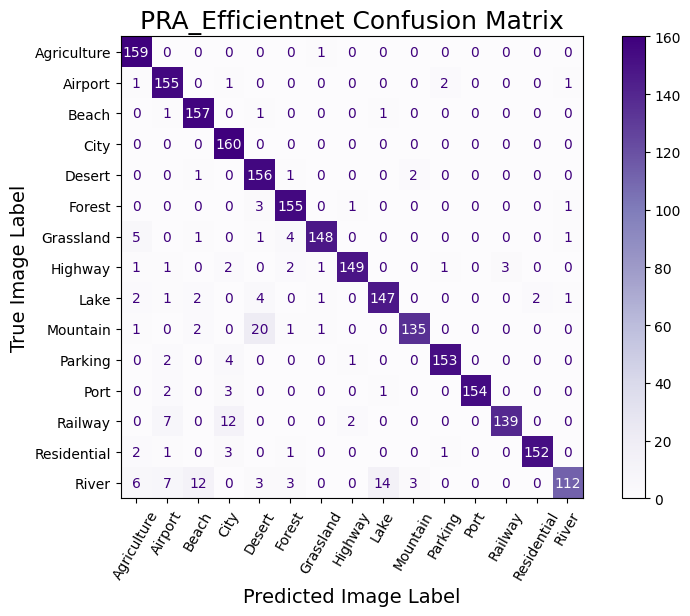

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_validate
#____________________Efficientnet Final Evaluation______________________________
print("\nEfficientnet Final Evaluation on Test Set:")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Use accuracy, precision, recall and f1 as the evaluation metrics.
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Efficientnet Test dataset Accuracy: {accuracy * 100:.2f}%")
print(f"Efficientnet Test dataset Precision: {precision * 100:.2f}%")
print(f"Efficientnet Test dataset Recall: {recall * 100:.2f}%")
print(f"Efficientnet Test dataset F1-score: {f1 * 100:.2f}%")

# Efficientnet Classification report.
print("\nEfficientnet Final classification report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Efficientnet Confusion matrix:
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Purples', xticks_rotation=60, ax=ax)
plt.title("PRA_Efficientnet Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Image Label", fontsize=14)
plt.ylabel("True Image Label", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()